Reference: [Probabilistic programming in Python
using PyMC3](https://peerj.com/articles/cs-55.pdf)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm

# Introduction

Y ~ $N(a + X^{T}b, \sigma^{2})$

Priors:

$a = N(0,10)$  
$b_{i} = N(0,10)$  
    
$\sigma = |N(0,1)|$  <-- Half-normal  = Non negative values 
  
  
# Generating Data  

Text(0,0.5,'Y')

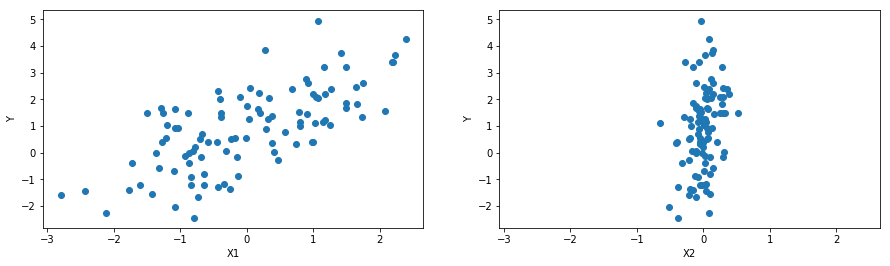

In [2]:
# Intialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

fig, axis = plt.subplots(1,2, sharex=True, figsize=[15,4])
axis[0].scatter(X1, Y)
axis[0].set_xlabel('X1')
axis[0].set_ylabel('Y')

axis[1].scatter(X2, Y)
axis[1].set_xlabel('X2')
axis[1].set_ylabel('Y')


# Model Specification

In [3]:
model = pm.Model()

with model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    betas = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    mu = alpha + betas[0]*X1 + betas[1]*X2
    
    y_obs = pm.Normal('y_obs', mu=mu, sd=sigma, observed=Y)
    

# Model Fitting

## Maximum a Posteriori (MAP) Point Estimation -   
  
The maximum a posteriori (MAP) estimate for a model, is the mode of the posterior
distribution and is generally found using numerical optimization methods. This is often
fast and easy to do, but only gives a point estimate for the parameters and can be misleading
if the mode isn’t representative of the distribution. PyMC3 provides this functionality with
the [find_MAP](https://pymc-devs.github.io/pymc/modelfitting.html#maximum-a-posteriori-estimates) function.

Obs: MAP can only handle variables whose dtype is `float`

* If MAP only generates point estimates, what is the difference between it and MLE? [Reference](https://wiseodd.github.io/techblog/2017/01/01/mle-vs-map/)

MAP is just the MLE estimator but including a weighting factor by the prior

In [4]:
map_estimate = pm.find_MAP(model=model)

logp = -149.58, ||grad|| = 12.242: 100%|██████████| 19/19 [00:00<00:00, 1749.35it/s]  


In [5]:
print(map_estimate)

{'alpha': array(0.90660093), 'beta': array([0.94848596, 2.60711845]), 'sigma_log__': array(-0.03771373), 'sigma': array(0.96298858)}


## MCMC sampling methods - Computing Summaries based on Sample Draws

Though finding the MAP is a fast and easy way of obtaining parameter estimates of
well-behaved models, it is limited because there is no associated estimate of uncertainty
produced with the MAP estimates. Instead, a simulation-based approach such as MCMC
can be used to obtain a Markov chain of values that, given the satisfaction of certain
conditions, are indistinguishable from samples from the posterior distribution.
To conduct MCMC sampling to generate posterior samples in PyMC3, we specify
a step method object that corresponds to a single iteration of a particular MCMC
algorithm, such as Metropolis, Slice sampling, or the No-U-Turn Sampler (NUTS).
PyMC3’s step_methods submodule contains the following samplers: NUTS, Metropolis,
Slice, HamiltonianMC, and BinaryMetropolis.

In [6]:
with model:
    starting_point = pm.find_MAP(model=model)
    steps = pm.NUTS(scaling=starting_point)
    
    trace = pm.sample(2000, steps, start=starting_point)

logp = -149.58, ||grad|| = 12.242: 100%|██████████| 19/19 [00:00<00:00, 2185.43it/s]  
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:02<00:00, 4118.15draws/s]


The left column consists of a smoothed histogram (using kernel density estimation) of
the marginal posteriors of each stochastic random variable while the right column contains
the samples of the Markov chain plotted in sequential order. The beta variable, being
vector-valued, produces two histograms and two sample traces, corresponding to both
predictor coefficients.

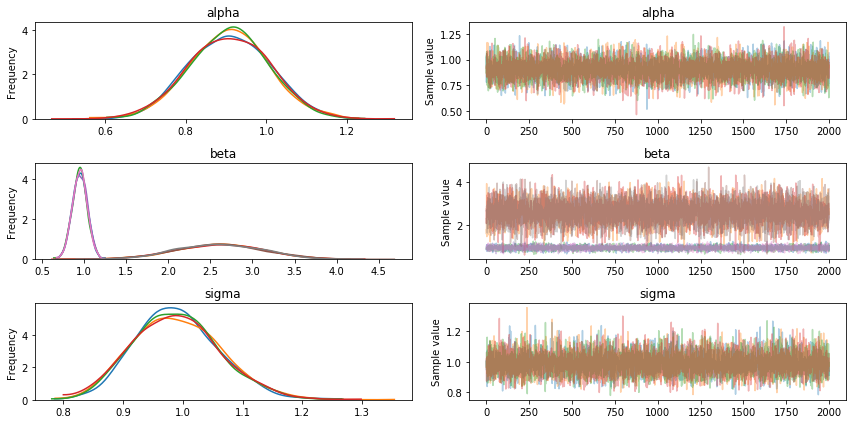

In [10]:
pm.traceplot(trace);

For a tabular summary, the summary function provides a text-based output of common
posterior statistics:


In [8]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.906647,0.098151,0.000846,0.717287,1.097960,12351.748352,0.999777
beta__0,0.949077,0.088219,0.000834,0.778395,1.123581,12018.102438,0.999980
beta__1,2.601938,0.520448,0.004322,1.576867,3.604828,12299.880671,0.999776
sigma,0.989363,0.071572,0.000650,0.851088,1.127928,10543.842745,0.999858
